**DCGAN**   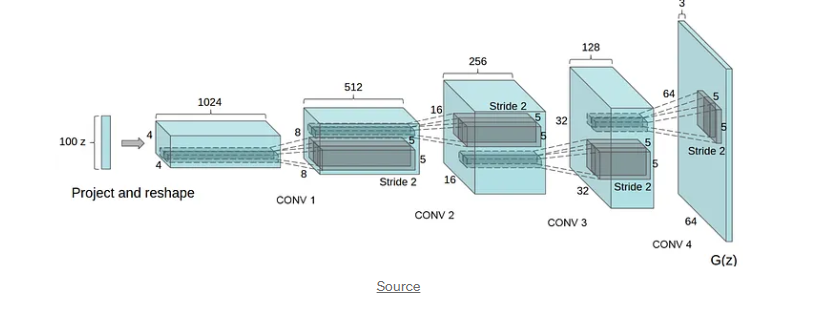
DCGAN is one popular design for GAN. It composes of convolution and transposed convolutional layers without max pooling or fully connected layers. The figure below is the network design for the generator. This example will be trained to generate MNIST digits. We will start the article with this most basic GAN model.

In [1]:
import tensorflow as tf

In [52]:

import glob
import matplotlib.pyplot as plt
import os
import PIL
from tensorflow.keras import layers
import time

epochs =50


In [3]:
from IPython import display

In [4]:
(train_images, train_labels),(_,_) =tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [6]:
train_images = train_images.reshape(train_images.shape[0],28,28,1).astype('float32')
train_images = (train_images-127.5)/127.5 #normalize images to [-1,1]
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [8]:
#batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [11]:
#generator

def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias = False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7,7,256)))
  assert model.output_shape == (None, 7,7,256) #none is the batch size
  model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),
                                   padding = 'same',use_bias = False))
  assert model.output_shape == (None,7,7,128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  model.add(layers.Conv2DTranspose(64,(5,5), strides = (2,2),
                                   padding ='same', use_bias = False))
  assert model.output_shape == (None, 14,14,64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1,(5,5), strides = (2,2), padding ='same',
                                   use_bias =False, activation ='tanh'))
  assert model.output_shape==(None, 28,28,1)

  return model


generator = make_generator_model()

In [12]:
#discrimunator:


def make_discriminator_model():
  model =  tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5,5), strides =(2,2), padding ='same', input_shape=[28,28,1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))


  model.add(layers.Conv2D(128,(5,5), strides =(2,2), padding ='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))


  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

discriminator = make_discriminator_model()

In [13]:
#Here is the loss function. For the discriminator, we expect real images to be labeled as one and generated images to be 0. For the generator loss, we want the discriminator to classify it as 1.

def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output),fake_output)



In [56]:
# Assuming cross_entropy is defined
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Assuming batch_size and noise_dim are defined
batch_size = 256
noise_dim = 100

In [16]:
#the optimizer and the checkpoints:

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
checkpoint_dir = './training_checkpoints'
checkpount_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

checkpoint_dir = './training_checkpoints'
checkpount_prefix = os.path.join(checkpoint_dir,"ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)


In [55]:
# Assuming generator and checkpoint are already defined
# Ensure seed is defined
seed = tf.random.normal([16, 100])


In [31]:
#training steps:

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in datset:
      train_step(image_batch)

      #produce images for the GIf as we go

      display.clear_output(wait=True)
      generate_and_save_images(generator, epoch+1,seed)


      #sqave the model every 15 epochs
      if(epoch + 1)%15 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

      print('Time for epoch {} is {}  sec.'.format(epoch+1, time.time() - start))
  #generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

In [57]:
# Placeholder for train_step function
@tf.function
def train_step(images):
    # Define the train step logic here
    # Example (replace with your actual logic):
    noise = tf.random.normal([batch_size, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [49]:
#the training loop

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

      #produce images for the GIf as we go

      display.clear_output(wait=True)
      generate_and_save_images(generator, epoch+1,seed)


      #sqave the model every 125 epochs
      if(epoch + 1)%15 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

      print('Time for epoch {} is {}  sec.'.format(epoch+1, time.time() - start))
  #generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

Next, we start the model training. Previously, we randomly sample sixteen z values. At the end of each epoch training, we generate 16 images for these 16 z values. We save these images and once the training is done, we stitch them together as an animated GIF. So for each sampled z, we can see how the generated images change as the training progress.

In [59]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training = False)
  fig = plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(predictions[i,:,:,0] * 127.5 +127.5, cmap ='gray')
    plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()




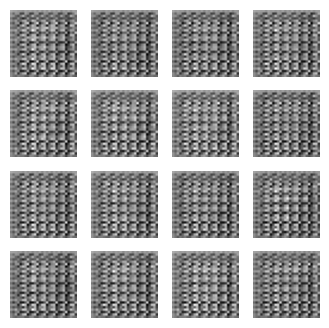

Time for epoch 1 is 436.4191517829895  sec.


In [ ]:
train(train_dataset, epochs)

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


#display a single images using the epoch number

def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(epochs).show()

anim_file = 'dcgan.gif'


with imageio.get_writer(anim_file, mode= 'I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.inread(filename)
    writer.append_data(image)
image=imageio.imread(filename)
writer.append_data(image)
